In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!cd '/content/gdrive/My Drive/'

Mounted at /content/gdrive


In [3]:
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
from pandas import read_csv
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sqlalchemy import true
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten
from keras.layers import Reshape

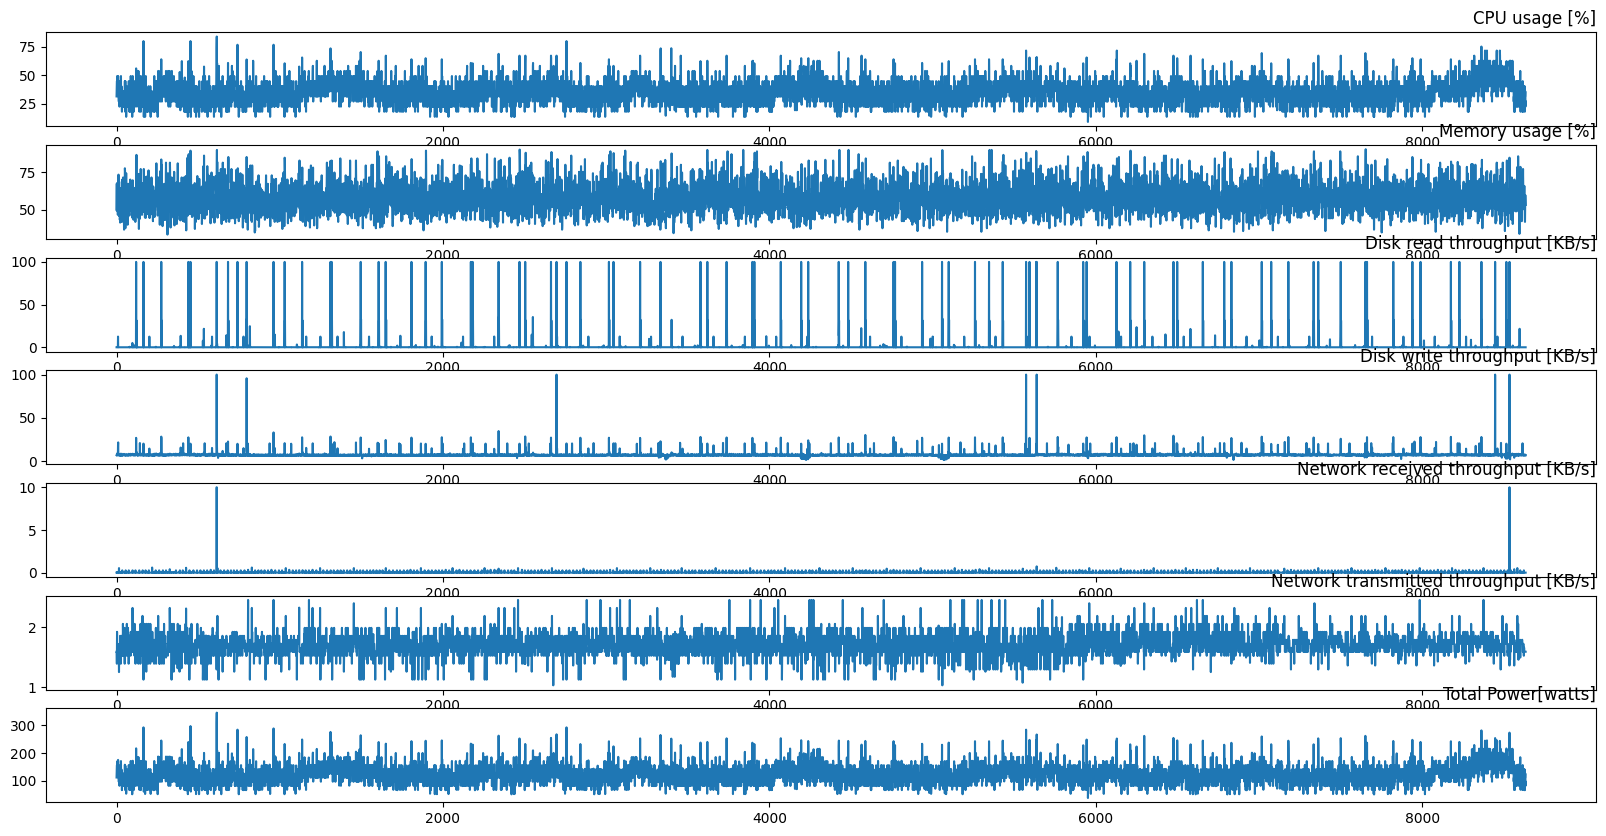

In [52]:
dataset = read_csv('gdrive/My Drive/archive/final_streaming.csv',header=0, index_col=0, engine='python')
values = dataset.values
groups = [0,1,2,3,4,5,6]
i = 1
pyplot.figure(figsize=(20,10))
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=1, loc='right')
 i += 1
pyplot.show()

In [5]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
 # put it all together
 agg = concat(cols, axis=1)
 agg.columns = names
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

data = series_to_supervised(scaled,2,1)
print(data)

      var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2      0.298507   0.586781        0.0   0.055049   0.000000   0.393333   
3      0.417910   0.281000        0.0   0.057751   0.000000   0.393333   
4      0.477612   0.479340        0.0   0.057075   0.006667   0.253333   
5      0.477612   0.603304        0.0   0.074637   0.000000   0.626667   
6      0.537313   0.363639        0.0   0.056400   0.000000   0.393333   
...         ...        ...        ...        ...        ...        ...   
8630   0.417910   0.413221        0.0   0.054374   0.000000   0.393333   
8631   0.119403   0.198353        0.0   0.053023   0.000000   0.393333   
8632   0.298507   0.148765        0.0   0.057075   0.000000   0.393333   
8633   0.298507   0.272735        0.0   0.055724   0.000000   0.393333   
8634   0.358209   0.462812        0.0   0.062479   0.000000   0.393333   

      var7(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  ...  var5(t-1)  var6(t-1)  \
2      0.240368   0.417910   0.2

In [54]:
data.drop(data.columns[[-2,-3,-4,-5,-6,-7]], axis=1, inplace=True)
data.drop(data.columns[[6,13]], axis=1, inplace=True)

print (data.head())


   var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var6(t-2)  \
2   0.298507   0.586781        0.0   0.055049   0.000000   0.393333   
3   0.417910   0.281000        0.0   0.057751   0.000000   0.393333   
4   0.477612   0.479340        0.0   0.057075   0.006667   0.253333   
5   0.477612   0.603304        0.0   0.074637   0.000000   0.626667   
6   0.537313   0.363639        0.0   0.056400   0.000000   0.393333   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var7(t)  
2   0.417910   0.281000        0.0   0.057751   0.000000   0.393333  0.382074  
3   0.477612   0.479340        0.0   0.057075   0.006667   0.253333  0.387828  
4   0.477612   0.603304        0.0   0.074637   0.000000   0.626667  0.429352  
5   0.537313   0.363639        0.0   0.056400   0.000000   0.393333  0.333214  
6   0.417910   0.347113        0.0   0.055724   0.000000   0.393333  0.284997  


In [55]:
values = data.values


# split into x and y dataset
values_x , values_y = values[:, :-1] , values[:, -1]

print (f"value_x shape is :{values_x.shape}")
print (f"value_y shape is :{values_y.shape}")
#split data to train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(values_x, values_y, test_size=0.3, shuffle=False)


"""x_train = x_train.reshape((  x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape(( x_test.shape[0], x_test.shape[1], 1))"""
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 2, 6))
x_test = x_test.reshape((x_test.shape[0], 2, 6))

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
print (x_train.size)
print (x_test.size)


value_x shape is :(8633, 12)
value_y shape is :(8633,)
(6043, 2, 6)
(6043,)
(2590, 2, 6)
(2590,)
72516
31080


In [56]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(2, 6)))
model.add(Reshape((64,)))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 64)             832       
                                                                 
 reshape_3 (Reshape)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7105 (27.75 KB)
Trainable params: 7105 (27.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
# fit the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/100
95/95 [==============================] - 2s 7ms/step - loss: 0.6002 - accuracy: 1.6548e-04 - val_loss: 0.5905 - val_accuracy: 0.0000e+00
Epoch 2/100
95/95 [==============================] - 1s 5ms/step - loss: 0.5862 - accuracy: 1.6548e-04 - val_loss: 0.5881 - val_accuracy: 0.0000e+00
Epoch 3/100
95/95 [==============================] - 1s 5ms/step - loss: 0.5851 - accuracy: 1.6548e-04 - val_loss: 0.5880 - val_accuracy: 0.0000e+00
Epoch 4/100
95/95 [==============================] - 0s 5ms/step - loss: 0.5845 - accuracy: 1.6548e-04 - val_loss: 0.5870 - val_accuracy: 0.0000e+00
Epoch 5/100
95/95 [==============================] - 1s 6ms/step - loss: 0.5839 - accuracy: 1.6548e-04 - val_loss: 0.5869 - val_accuracy: 0.0000e+00
Epoch 6/100
95/95 [==============================] - 0s 5ms/step - loss: 0.5838 - accuracy: 1.6548e-04 - val_loss: 0.5865 - val_accuracy: 0.0000e+00
Epoch 7/100
95/95 [==============================] - 1s 7ms/step - loss: 0.5838 - accuracy: 1.6548e-04 - v

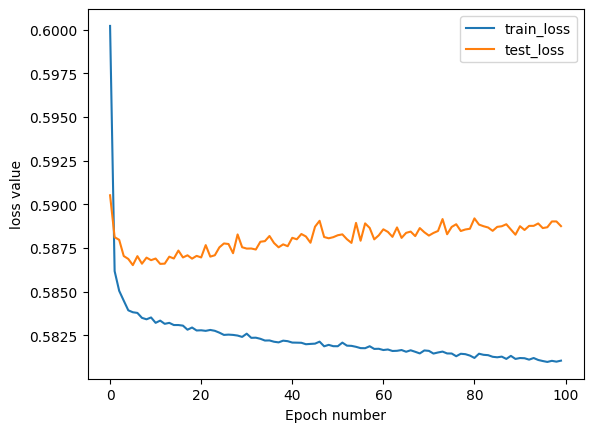

In [58]:
# plot history
fig,ax = pyplot.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='test_loss')
ax.set_xlabel('Epoch number')
ax.set_ylabel('loss value')
ax.legend()
pyplot.show()

In [59]:
# make predictions
y_pred = model.predict(x_test)


81/81 [==============================] - 0s 2ms/step


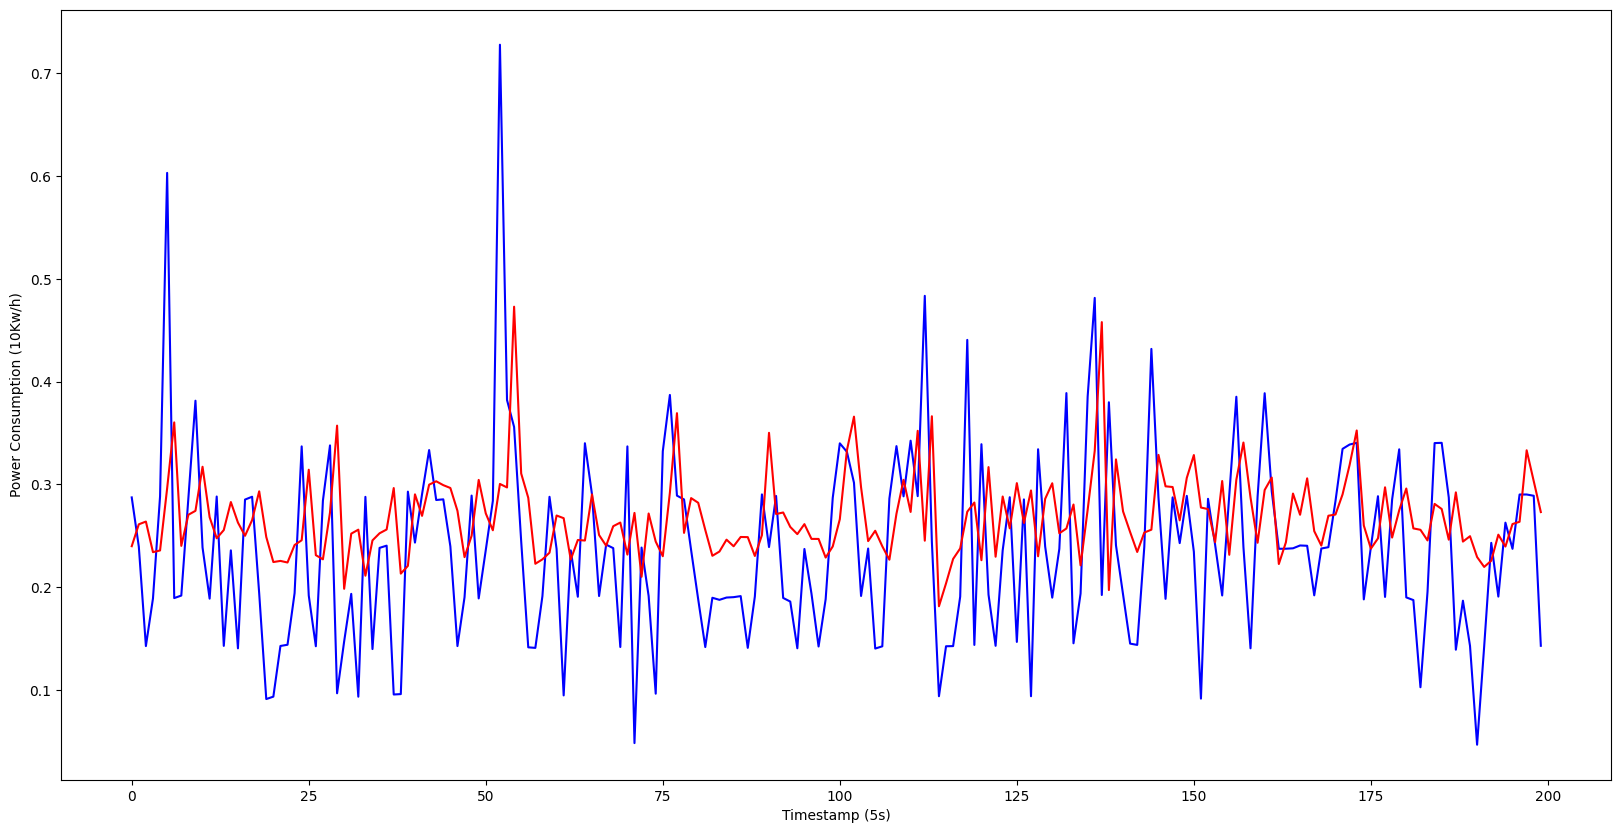

range(0, 2590) range(0, 2590)


In [60]:
a = range(len(y_pred))
b = range(len(y_test))
fig, ax = pyplot.subplots(figsize=(20,10))
ax.plot(range(200), y_test[200:400], 'b', label='Actual')
ax.plot(range(200), y_pred[200:400], 'r', label='Predicted')
ax.set_xlabel('Timestamp (5s)')
ax.set_ylabel('Power Consumption (10Kw/h)')

pyplot.show()

print (a,b)

In [61]:
from numpy import sqrt
from sklearn.metrics import mean_absolute_error
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmae = sqrt(mean_absolute_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test RMAE: %.3f' % rmae)

Test RMSE: 0.103
Test RMAE: 0.279
